# Retail Data Wrangling and Analytics

In [1]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#install psql "driver"
!pip3 install psycopg2-binary

In [3]:
import psycopg2
user = "postgres"
password = "password"
host = "jrvs-psql"
port = 5432
db = "postgres"
table = "retail"
# connection object. Assumes postgres runs in the same docker network
conn = psycopg2.connect(f"host='{host}' port='{port}' user='{user}' password='{password}' dbname='{db}'")


retail_df = pd.read_sql(f"SELECT * FROM {table}", conn)
retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [4]:
csv_path = "https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv"
retail_df = pd.read_csv(csv_path)
retail_df.rename(columns = lambda s: s.replace(' ','') , inplace = True)
retail_df.InvoiceDate = pd.to_datetime(retail_df.InvoiceDate)


# Total Invoice Amount Distribution

In [5]:
invoice_amount_df = (retail_df.Quantity*retail_df.Price).groupby(retail_df.Invoice).sum()
# removing negative invoices
invoice_amount_df = invoice_amount_df[invoice_amount_df > 0]

Minimum:0.19
Mean:523.30
Median:304.32
Mode:15.00
Maximum:168469.60

Minimum:0.19
Mean:271.68
Median:256.24
Mode:15.00
Maximum:724.25



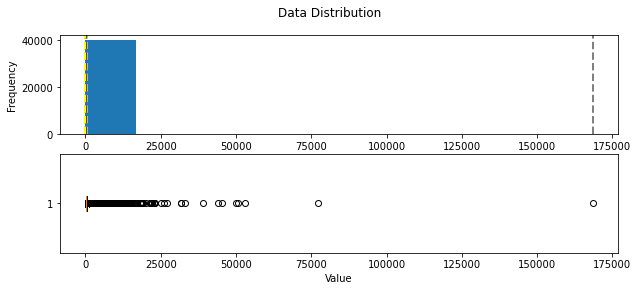

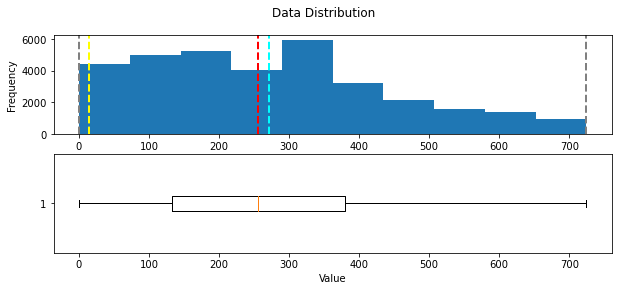

In [6]:
def show_distribution(var_data):
    from matplotlib import pyplot as plt

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle('Data Distribution')

    # Show the figure
    fig.show()

show_distribution(invoice_amount_df)

# Removing outliers above the 85th quantile
invoice_amount_df_no_outliers = invoice_amount_df[invoice_amount_df < invoice_amount_df.quantile(0.85)]
show_distribution(invoice_amount_df_no_outliers)


# Monthly Placed and Canceled Orders

In [7]:
df_orders = retail_df[['Invoice', 'InvoiceDate']].copy()
df_orders_canceled = df_orders[df_orders.Invoice.str.startswith('C') == 1]

In [8]:
total_orders_by_month = df_orders.groupby(pd.Grouper(key='InvoiceDate', freq='M')).count()
total_orders_by_month.rename(columns={"Invoice":"Placement"}, inplace=True)

canceled_orders_by_month = df_orders_canceled.groupby(pd.Grouper(key='InvoiceDate', freq='M')).count()
canceled_orders_by_month.rename(columns={"Invoice":"Cancellation"}, inplace=True)

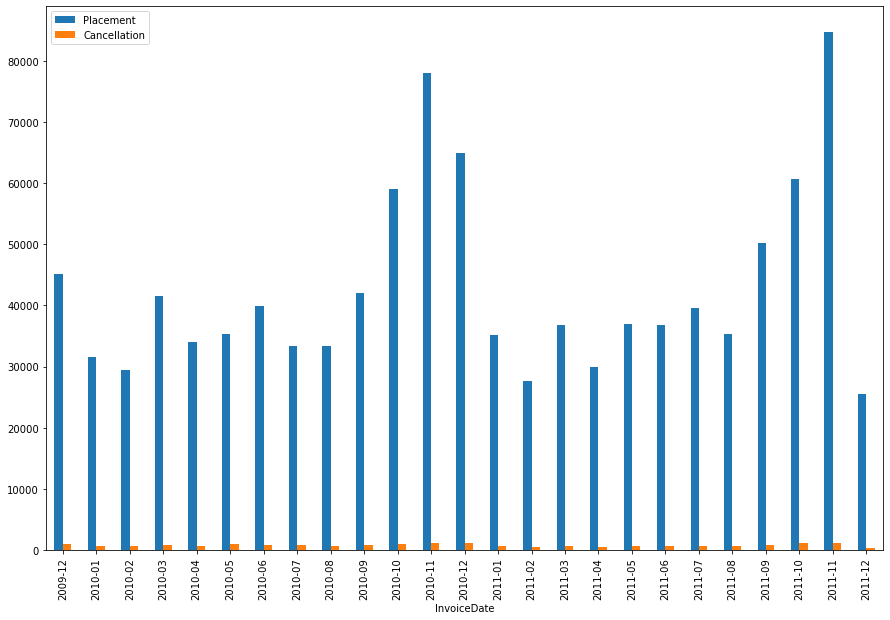

In [9]:
df = pd.concat([total_orders_by_month, canceled_orders_by_month.Cancellation], axis = 1)
ax = df.plot(y=['Placement','Cancellation'], kind='bar', figsize=(15,10))
ax.set_xticklabels(df.index.strftime('%Y-%m'));

# Monthly Sales

In [10]:
total_sales = pd.concat([retail_df.InvoiceDate, retail_df.Quantity * retail_df.Price], axis=1)
total_sales.columns = ["SalesMonth", "MonthlySales"]
total_sales_by_month = total_sales.groupby(pd.Grouper(key='SalesMonth', freq='M')).sum()

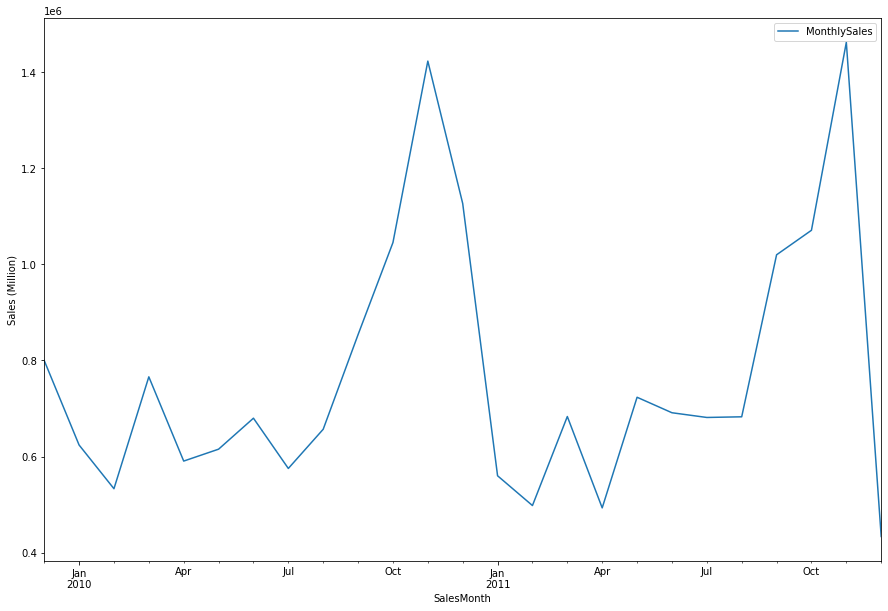

In [11]:
ax1 = total_sales_by_month.plot(kind = 'line', figsize=(15,10))
ax1.set_ylabel("Sales (Million)");

# Monthly Sales Growth


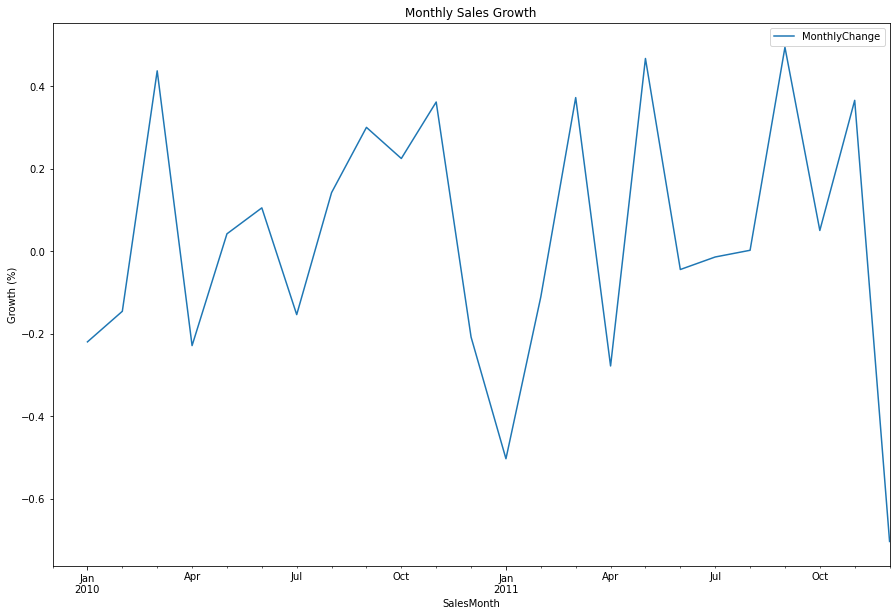

In [12]:
total_sales_by_month_growth = total_sales_by_month.pct_change()
total_sales_by_month_growth.rename(columns={"MonthlySales":"MonthlyChange"}, inplace=True)
ax2 = total_sales_by_month_growth.plot(kind = 'line', figsize=(15,10))
ax2.set_ylabel("Growth (%)");
ax2.set_title("Monthly Sales Growth");

# Monthly Active Users

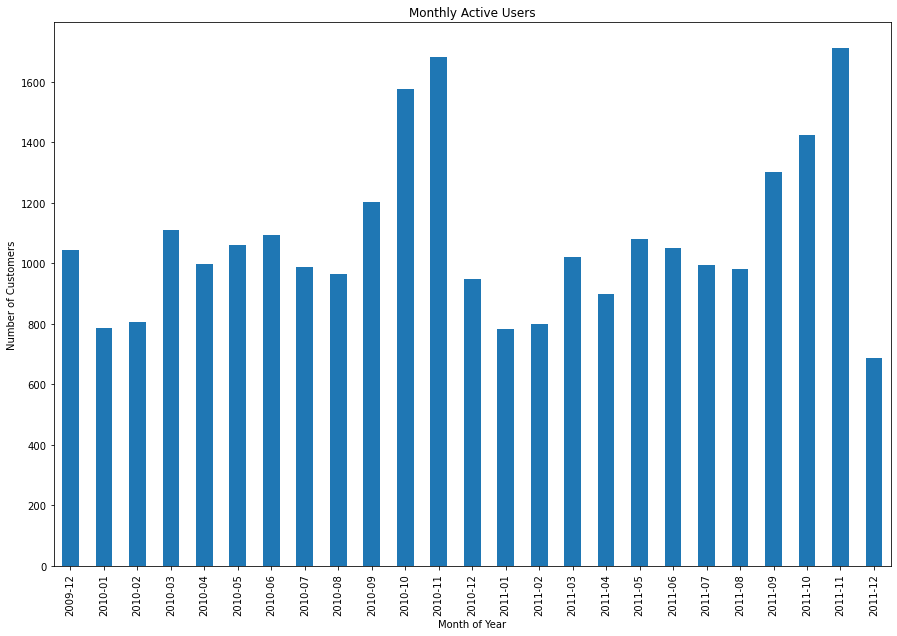

In [13]:
customers_by_month = retail_df.groupby(pd.Grouper(key='InvoiceDate', freq='M')).CustomerID
num_customers_by_month = customers_by_month.nunique()
ax3 = num_customers_by_month.plot(kind = 'bar', figsize=(15,10))
ax3.set_ylabel("Number of Customers");
ax3.set_xlabel("Month of Year");
ax3.set_title("Monthly Active Users");
ax3.set_xticklabels(df.index.strftime('%Y-%m'));

# New and Existing Users



In [14]:
customers_joining_date = retail_df.groupby("CustomerID")["InvoiceDate"].min().dt.to_period('M').dt.to_timestamp()
customers_joining_date.name="JoiningMonth"

In [15]:
df_merged = retail_df.merge(right = customers_joining_date, on="CustomerID", how="left")

In [16]:
is_new_user = (df_merged.JoiningMonth == df_merged.InvoiceDate.dt.to_period('M').dt.to_timestamp())
df_merged["IsNewUser"] = is_new_user

In [17]:
new_count = []
existing_count = []
idx = []
for group_name, group_df in df_merged.groupby([pd.Grouper(key='InvoiceDate', freq='M')]):
    group_df_unique_customers = group_df.drop_duplicates(subset="CustomerID", keep="first")
    new_count.append(sum(group_df_unique_customers.IsNewUser == True))
    existing_count.append(sum(group_df_unique_customers.IsNewUser == False))
    idx.append(group_df.iloc[0]['InvoiceDate'])

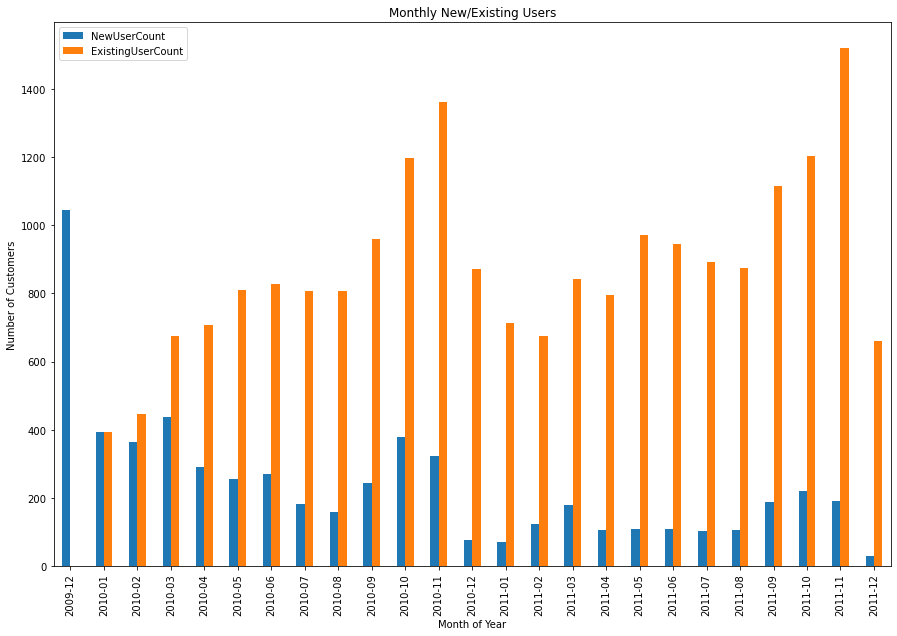

In [18]:
new_ex = pd.DataFrame({'NewUserCount':new_count, 'ExistingUserCount': existing_count}, index=idx)
ax4 = new_ex.plot(kind='bar', figsize=(15,10))
ax4.set_ylabel("Number of Customers");
ax4.set_xlabel("Month of Year");
ax4.set_title("Monthly New/Existing Users");
ax4.set_xticklabels(new_ex.index.strftime('%Y-%m'));

## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

In [19]:
#preparing data
df_rfm = retail_df.copy()
df_rfm['TotalPrice'] = df_rfm['Price']*df_rfm['Quantity']
df_rfm = df_rfm[df_rfm['Quantity'] > 0]
df_rfm = df_rfm[df_rfm['TotalPrice'] > 0]
df_rfm.dropna(inplace = True)

In [20]:
# finding Recency and Monetary values.
today = df_rfm['InvoiceDate'].max()
df_x = df_rfm.groupby('CustomerID').agg({'TotalPrice': lambda x: x.sum(), #monetary value
                                        'InvoiceDate': lambda x: (today - x.max()).days}) #recency value
df_y = df_rfm.groupby(['CustomerID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})
df_z = df_y.groupby('CustomerID').agg({'TotalPrice': lambda x: len(x)}) 
#finding the frequency value per capita
#creating the RFM table
rfm_table= pd.merge(df_x,df_z, on='CustomerID')
rfm_table.columns = ['Monetary', 'Recency','Frequency']

In [21]:
#RFM score values 
rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'],5,labels=[5,4,3,2,1])
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'],5,labels=[1,2,3,4,5])
#calculation of the RFM score
rfm_table["RFM_SCORE"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12346.0,77556.46,325,12.0,2,5,5,255
12347.0,5633.32,1,8.0,5,4,5,545
12348.0,2019.40,74,5.0,3,4,4,344
12349.0,4428.69,18,4.0,5,3,5,535
12350.0,334.40,309,1.0,2,1,2,212


# RFM Segmentation

In [22]:
#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
#creation of segment variable
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
CustomerID,,,,,,,,
12346.0,77556.46,325,12.0,2,5,5,255,Can't Lose
12347.0,5633.32,1,8.0,5,4,5,545,Champions
12348.0,2019.40,74,5.0,3,4,4,344,Loyal Customers
12349.0,4428.69,18,4.0,5,3,5,535,Potential Loyalists
12350.0,334.40,309,1.0,2,1,2,212,Hibernating


In [23]:
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency        Frequency            Monetary      
                           mean count       mean count          mean count
Segment                                                                   
About to Sleep       106.106494   385   1.361039   385    534.069722   385
At Risk              371.671979   753   3.904382   753   1382.101434   753
Can't Lose           330.225352    71  15.929577    71   8355.677634    71
Champions              7.560335   837  19.339307   837  10901.129875   837
Hibernating          458.281024  1523   1.252791  1523    438.031466  1523
Loyal Customers       66.068906  1161   9.838071  1161   4211.839160  1161
Need Attention       112.357143   266   3.154135   266   1283.658120   266
New Customers          9.500000    54   1.000000    54    360.667407    54
Potential Loyalists   24.756303   714   2.591036   714   1155.714749   714
Promising             37.833333   114   1.000000   114    319.425614   114